Straighten an image based on a mask using a mesh of points

This is the mask and image we will use:

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


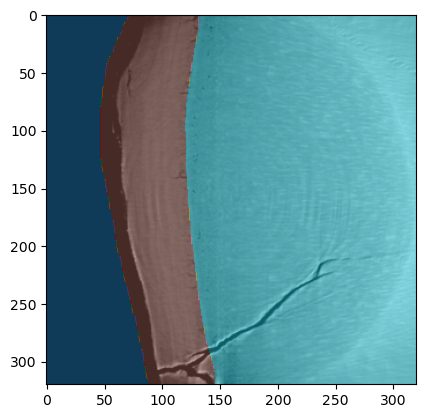

In [14]:
""" Display the image and mask """
import pickle
import matplotlib.pyplot as plt

with open("cementum_data.pickle", "rb") as data:
    _, _, test_images, test_masks = pickle.load(data)


# Just pick the first image for now
image, mask = test_images[0], test_masks[0]
plt.imshow(image, cmap="grey")
plt.imshow(mask, cmap="tab10", alpha=0.5)

We'll first identify the two edges and fit polynomials to them:

In [15]:
"""
Convert the masks from integers to uint8

"""
import numpy as np

assert (np.unique(mask) == [0, 1, 2]).all()

normalised_mask = (
    (mask - np.min(mask)) * 255.0 / (np.max(mask) - np.min(mask))
).astype(np.uint8)

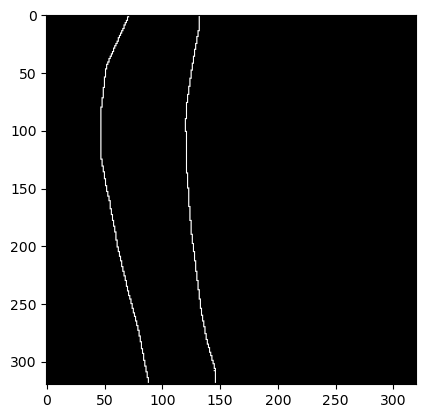

In [16]:
"""
Show the mask edge identification

"""
from cementum import straighten

# Find edges
edges = straighten.find_edges(normalised_mask)

# Choose a value above which to consider an edge
edge_threshold = 10
edges[edges >= edge_threshold] = 1.0
plt.imshow(edges, cmap="grey")

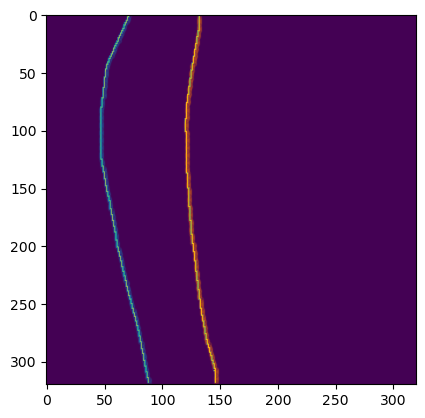

In [17]:
"""
Show how we identify the first and second edge

"""
first_edge, second_edge = straighten._identify_edges(edges)

plt.imshow(edges)
plot_kw = {"marker": ".", "alpha": 0.1}
plt.plot(first_edge[:, 0], first_edge[:, 1], **plot_kw)
plt.plot(second_edge[:, 0], second_edge[:, 1], **plot_kw)

Text(0.5, 1.0, 'Polynomial fits to edges')

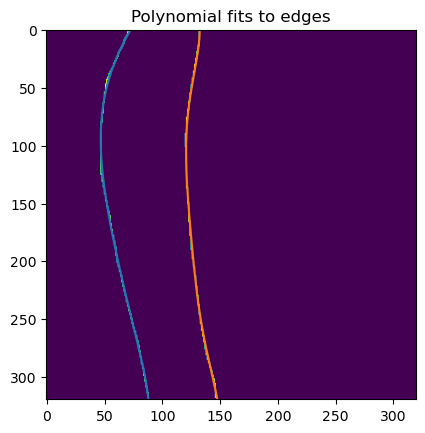

In [18]:
"""
Fit a polynomial to the smoothed edges

"""
plt.imshow(edges)

poly_degree = 6

first_poly = straighten._fit_polynomial(first_edge, poly_degree)
second_poly = straighten._fit_polynomial(second_edge, poly_degree)

y_vals = np.arange(0, image.shape[0])

plt.plot(first_poly(y_vals), y_vals)
plt.plot(second_poly(y_vals), y_vals)

plt.title("Polynomial fits to edges")

Now we need to find the area between the two curves, and a rectangle of equivalent area. We'll set this rectangle's height to the average of the two curve lengths:

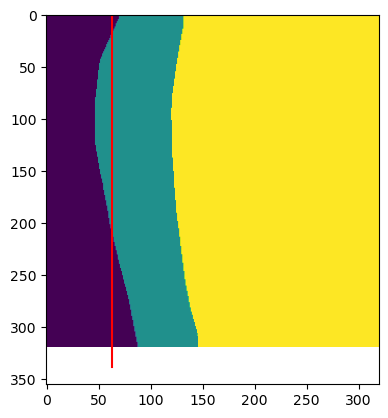

In [19]:
"""
Find the rectangle that we will map our region onto

"""
from shapely import Polygon


def length(curve: np.ndarray) -> float:
    return np.sum(np.sqrt(np.diff(curve[:, 0]) ** 2 + np.diff(curve[:, 1]) ** 2))


def area(curve1: np.ndarray, curve2: np.ndarray) -> float:
    # Create a shapely polygon
    # Reverse the second curve so that the polygon is closed and the points describe
    # a path around it in the right sense
    return Polygon(np.vstack([curve1, curve2[::-1]])).area


rectangle_height = (length(first_edge) + length(second_edge)) / 2
total_area = area(first_edge, second_edge)

rectangle_width = total_area / rectangle_height

plt.imshow(mask)
plt.plot([rectangle_width] * 2, [0, rectangle_height], color="red")

First we'll use an evenly spaced Cartesian grid as our mesh...

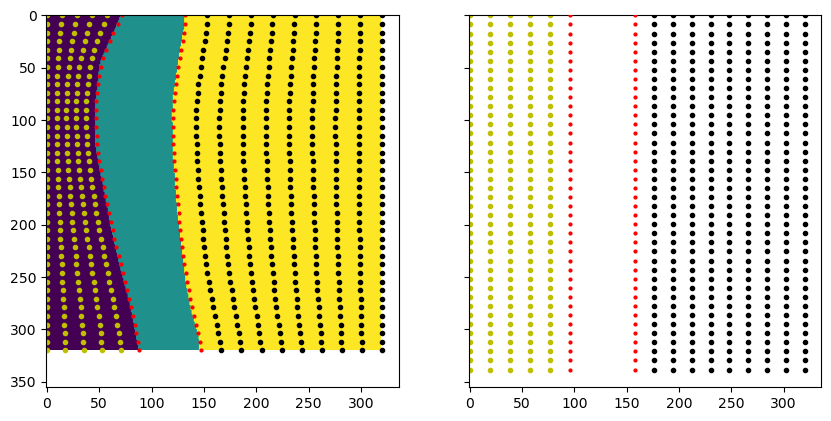

In [54]:
"""
Create grids of points to map to/from

"""
n_x, n_y = 2, 40
n_left, n_right = 5, 10

plot_kw = {"marker": "o", "linestyle": "none"}

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for axis in axes:
    axis.set_aspect("equal")

# Find y values for the midpoint of the two lines
curve_y = np.linspace(0, mask.shape[1], n_y, endpoint=True)

# Find x values for the curves
curve_pts = []
for y_val in curve_y:
    for x_val in np.linspace(first_poly(y_val), second_poly(y_val), n_x, endpoint=True):
        curve_pts.append([x_val, y_val])
curve_pts = np.array(curve_pts)

# Find values on the left of the curve
left_curve_pts = []
for y_val in curve_y:
    for x_val in np.linspace(0, first_poly(y_val), n_left, endpoint=False):
        left_curve_pts.append([x_val, y_val])
left_curve_pts = np.array(left_curve_pts)

# Find values on the right of the curve
right_curve_pts = []
right_straight_pts = []
for y_val in curve_y:
    for x_val in np.linspace(
        second_poly(y_val), image.shape[0], n_right, endpoint=True
    )[1:]:
        right_curve_pts.append([x_val, y_val])
right_curve_pts = np.array(right_curve_pts)

axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], color="r", **plot_kw, markersize=2)
axes[0].plot(left_curve_pts[:, 0], left_curve_pts[:, 1], color="y", **plot_kw, markersize=3)
axes[0].plot(right_curve_pts[:, 0], right_curve_pts[:, 1], color="k", **plot_kw, markersize=3)
axes[0].imshow(mask)

# Create a rectangle of points
rect_x = np.linspace(0, rectangle_width, n_x, endpoint=True)
rect_y = np.linspace(0, rectangle_height, n_y, endpoint=True)
X, Y = np.meshgrid(rect_x, rect_y)
rect_pts = np.dstack([X.ravel(), Y.ravel()])[0]

# Offset them by a bit
offset = np.mean(curve_pts[:, 0])
rect_pts[:, 0] += offset
left_boundary = 0
right_boundary = mask.shape[0]

# Find values on the left of the rectangle
left_rect_pts = []
for y_val in rect_y:
    for x_val in np.linspace(left_boundary, offset, n_left, endpoint=False):
        left_rect_pts.append([x_val, y_val])
left_rect_pts = np.array(left_rect_pts)

# Find values on the right of the rectangle
right_rect_pts = []
for y_val in rect_y:
    for x_val in np.linspace(
        offset + rectangle_width, right_boundary, n_right, endpoint=True
    )[1:]:
        right_rect_pts.append([x_val, y_val])
right_rect_pts = np.array(right_rect_pts)

axes[1].plot(rect_pts[:, 0], rect_pts[:, 1], color="r", **plot_kw, zorder=10, markersize=2)
axes[1].plot(left_rect_pts[:, 0], left_rect_pts[:, 1], color="y", **plot_kw, markersize=3)
axes[1].plot(right_rect_pts[:, 0], right_rect_pts[:, 1], color="k", **plot_kw, markersize=3)

# Concatenate all the points together
curve_pts = np.vstack([left_curve_pts, curve_pts, right_curve_pts])
curve_pts = curve_pts[np.lexsort((curve_pts[:, 1], curve_pts[:, 0]))]

rect_pts = np.vstack([left_rect_pts, rect_pts, right_rect_pts])
rect_pts = rect_pts[np.lexsort((rect_pts[:, 1], rect_pts[:, 0]))]

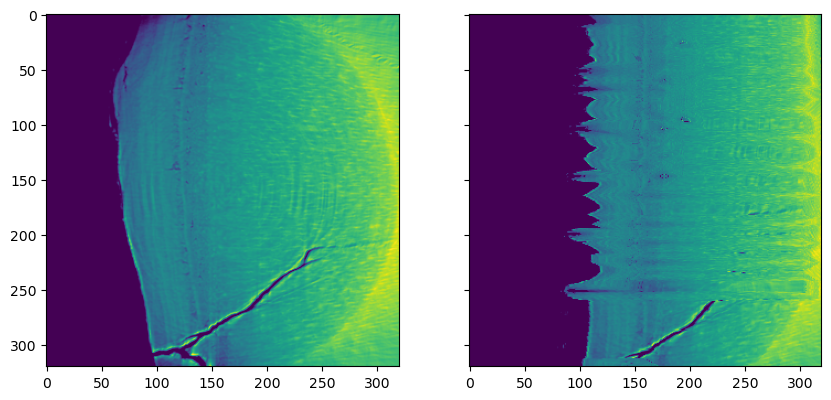

In [44]:
from matplotlib import colormaps, colors
from skimage.transform import warp, PiecewiseAffineTransform

# Estimate the transformation
transform = PiecewiseAffineTransform()
result = transform.estimate(curve_pts, rect_pts)
assert result

# Apply the transformation to the image
image_transformed = warp(image, transform.inverse, order=0, clip=False, cval=255)

# Display the straightened image
cmap = colormaps["viridis"]
cmap.set_over("white")
norm = colors.Normalize(vmin=0, vmax=254)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
axes[0].imshow(image, cmap=cmap, norm=norm)
axes[1].imshow(image_transformed, cmap=cmap, norm=norm)

It's now straight, but there is a noisy wavy edge on the left.

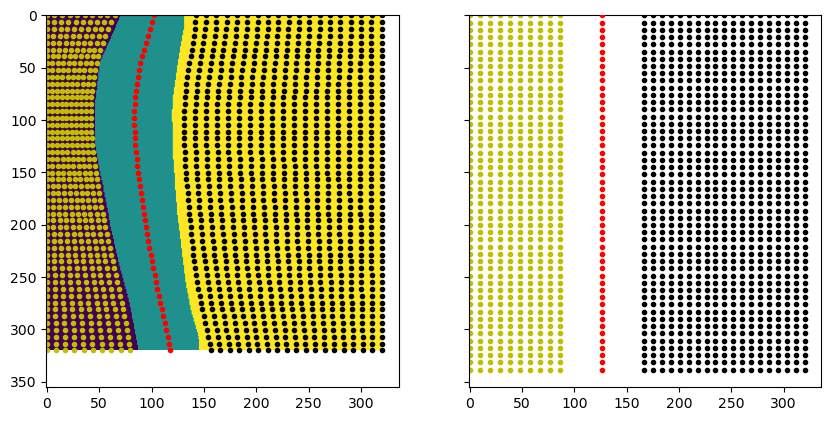

In [60]:
"""
Create grids of points to map to/from, this time in the centre

"""
n_y = 50
n_left, n_right = 10, 20

plot_kw = {"marker": "o", "markersize": 3, "linestyle": "none"}

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for axis in axes:
    axis.set_aspect("equal")

# Find y values for the midpoint of the two lines
curve_y = np.linspace(0, mask.shape[1], n_y, endpoint=True)

# Find values that track down the middle of the curve
curve_pts = []
for y_val in curve_y:
    curve_pts.append([(first_poly(y_val) + second_poly(y_val)) / 2, y_val])
curve_pts = np.array(curve_pts)

# Find values on the left of the curve
left_curve_pts = []
for y_val in curve_y:
    for x_val in np.linspace(0, first_poly(y_val), n_left, endpoint=False):
        left_curve_pts.append([x_val, y_val])
left_curve_pts = np.array(left_curve_pts)

# Find values on the right of the curve
right_curve_pts = []
right_straight_pts = []
for y_val in curve_y:
    for x_val in np.linspace(
        second_poly(y_val), image.shape[0], n_right, endpoint=True
    )[1:]:
        right_curve_pts.append([x_val, y_val])
right_curve_pts = np.array(right_curve_pts)

axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], color="r", **plot_kw)
axes[0].plot(left_curve_pts[:, 0], left_curve_pts[:, 1], color="y", **plot_kw)
axes[0].plot(right_curve_pts[:, 0], right_curve_pts[:, 1], color="k", **plot_kw)
axes[0].imshow(mask)

# Create a rectangle of points
rect_y = np.linspace(0, rectangle_height, n_y, endpoint=True)

# Offset them by a bit
offset = np.mean(curve_pts[:, 0])
rect_pts[:, 0] += offset
left_boundary = 0
right_boundary = mask.shape[0]

rect_pts = np.array([[offset + rectangle_width / 2, y] for y in rect_y])

# Find values on the left of the rectangle
left_rect_pts = []
for y_val in rect_y:
    for x_val in np.linspace(left_boundary, offset, n_left, endpoint=False):
        left_rect_pts.append([x_val, y_val])
left_rect_pts = np.array(left_rect_pts)

# Find values on the right of the rectangle
right_rect_pts = []
for y_val in rect_y:
    for x_val in np.linspace(
        offset + rectangle_width, right_boundary, n_right, endpoint=True
    )[1:]:
        right_rect_pts.append([x_val, y_val])
right_rect_pts = np.array(right_rect_pts)

axes[1].plot(rect_pts[:, 0], rect_pts[:, 1], color="r", **plot_kw, zorder=10)
axes[1].plot(left_rect_pts[:, 0], left_rect_pts[:, 1], color="y", **plot_kw)
axes[1].plot(right_rect_pts[:, 0], right_rect_pts[:, 1], color="k", **plot_kw)

# Concatenate all the points together
curve_pts = np.vstack([left_curve_pts, curve_pts, right_curve_pts])
curve_pts = curve_pts[np.lexsort((curve_pts[:, 1], curve_pts[:, 0]))]

rect_pts = np.vstack([left_rect_pts, rect_pts, right_rect_pts])
rect_pts = rect_pts[np.lexsort((rect_pts[:, 1], rect_pts[:, 0]))]

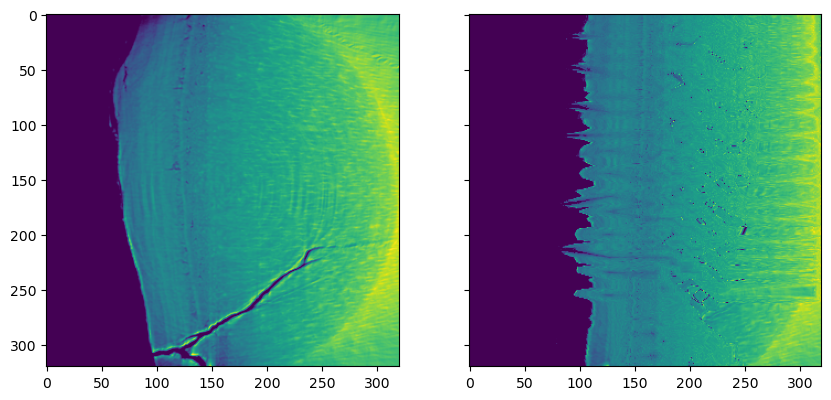

In [61]:
# Estimate the transformation
transform = PiecewiseAffineTransform()
result = transform.estimate(curve_pts, rect_pts)
assert result

# Apply the transformation to the image
image_transformed = warp(image, transform.inverse, order=0, clip=False, cval=255)

# Display the straightened image
cmap = colormaps["viridis"]
cmap.set_over("white")
norm = colors.Normalize(vmin=0, vmax=254)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
axes[0].imshow(image, cmap=cmap, norm=norm)
axes[1].imshow(image_transformed, cmap=cmap, norm=norm)